# Notebook to plot results from inpainting

[INFO] Subtypes: ['amyloid_plaque_patches', 'c_fos_positive_patches', 'cell_nucleus_patches', 'vessels_patches']
[INFO] amyloid_plaque_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_autumn_sweep_27/preds: collected 96 PSNR values
[INFO] amyloid_plaque_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_autumn_sweep_27_ntc/preds: collected 96 PSNR values
[INFO] amyloid_plaque_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_expert_sweep_31/preds: collected 96 PSNR values
[INFO] amyloid_plaque_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_expert_sweep_31_ntc/preds: collected 96 PSNR values
[INFO] amyloid_plaque_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_random/preds: collected 96 PSNR values
[INFO] amyloid_plaque_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_random_ntc/preds: collected 96 PSNR values


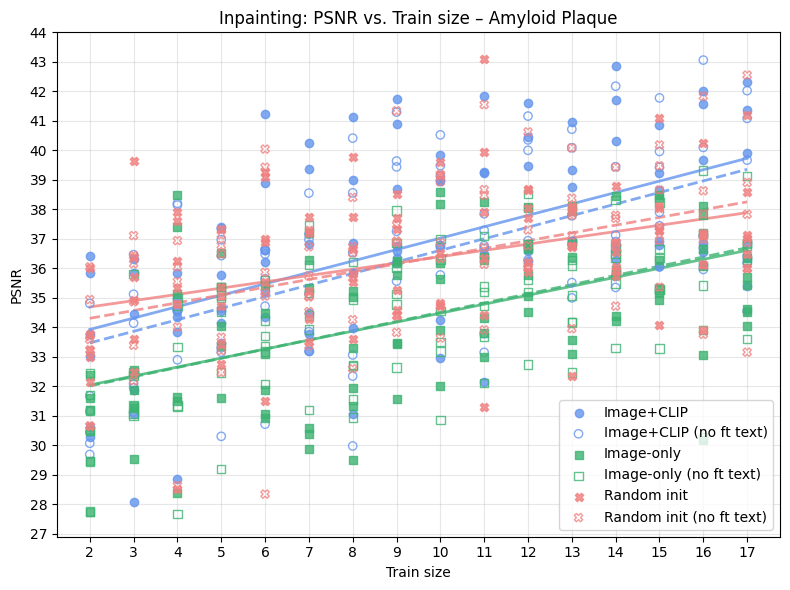

[INFO] c_fos_positive_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_autumn_sweep_27/preds: collected 6 PSNR values
[INFO] c_fos_positive_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_autumn_sweep_27_ntc/preds: collected 6 PSNR values
[INFO] c_fos_positive_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_expert_sweep_31/preds: collected 6 PSNR values
[INFO] c_fos_positive_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_expert_sweep_31_ntc/preds: collected 6 PSNR values
[INFO] c_fos_positive_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_random/preds: collected 6 PSNR values
[INFO] c_fos_positive_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_random_ntc/preds: collected 6 PSNR values


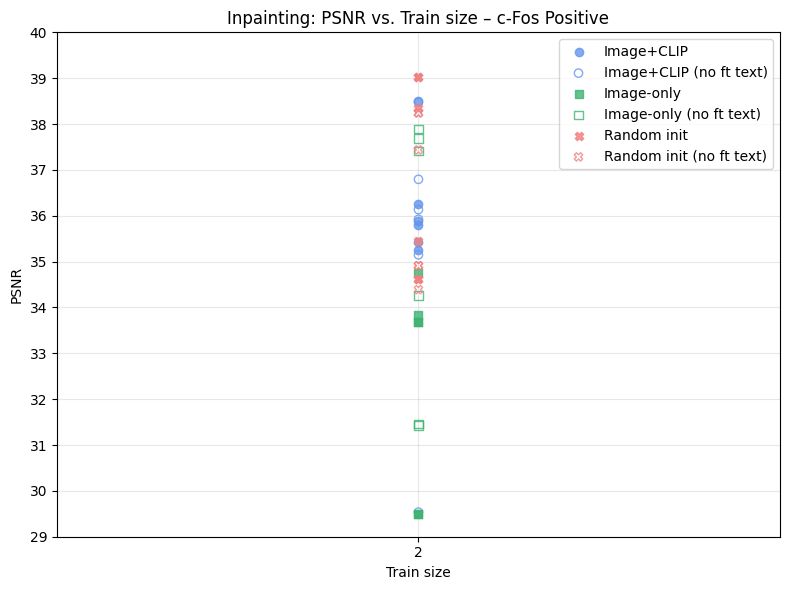

[INFO] cell_nucleus_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_autumn_sweep_27/preds: collected 132 PSNR values
[INFO] cell_nucleus_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_autumn_sweep_27_ntc/preds: collected 132 PSNR values
[INFO] cell_nucleus_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_expert_sweep_31/preds: collected 130 PSNR values
[INFO] cell_nucleus_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_expert_sweep_31_ntc/preds: collected 132 PSNR values
[INFO] cell_nucleus_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_random/preds: collected 132 PSNR values
[INFO] cell_nucleus_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_random_ntc/preds: collected 132 PSNR values


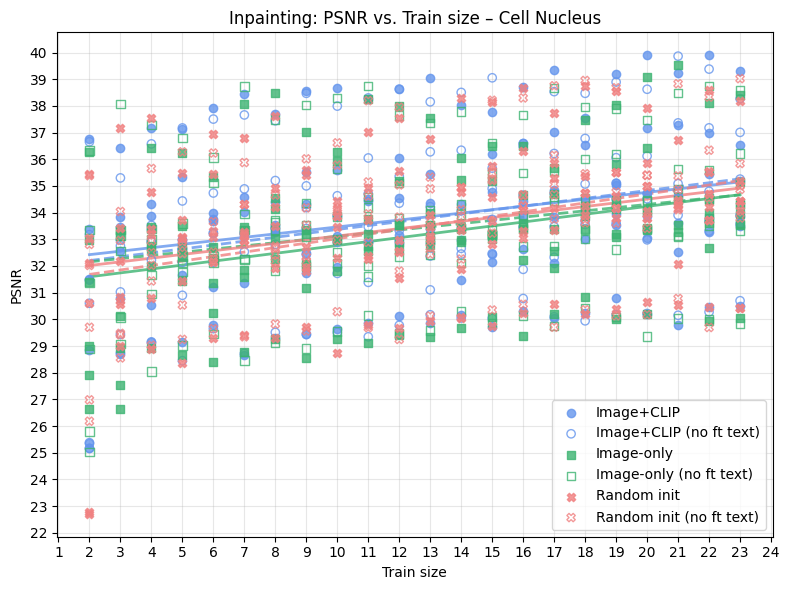

[INFO] vessels_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_autumn_sweep_27/preds: collected 114 PSNR values
[INFO] vessels_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_autumn_sweep_27_ntc/preds: collected 114 PSNR values
[INFO] vessels_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_expert_sweep_31/preds: collected 114 PSNR values
[INFO] vessels_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_expert_sweep_31_ntc/preds: collected 114 PSNR values
[INFO] vessels_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_random/preds: collected 114 PSNR values
[INFO] vessels_patches @ /midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_random_ntc/preds: collected 114 PSNR values


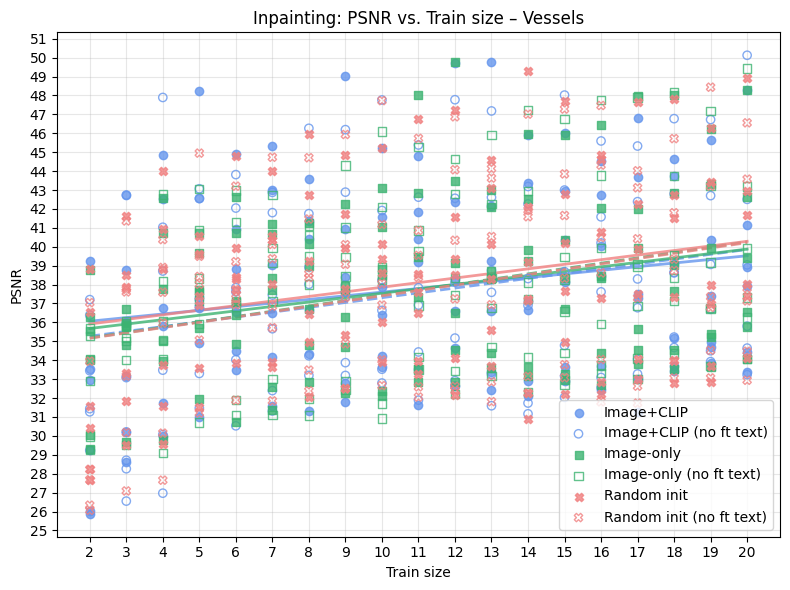

In [1]:
# ============================================================
# INPAINTING PSNR PLOTS – ALL SERIES ON SAME PLOT
# ============================================================

import csv
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import re


# --------------------------------------------------
# Pretty names for subtypes
# --------------------------------------------------
PRETTY_NAME = {
    "amyloid_plaque_patches": "Amyloid Plaque",
    "c_fos_positive_patches": "c-Fos Positive",
    "cell_nucleus_patches": "Cell Nucleus",
    "vessels_patches": "Vessels",
}


# --------------------------------------------------
# A single point from a metrics_test.csv
# --------------------------------------------------
@dataclass
class InpaintPoint:
    subtype: str
    train_size: int
    psnr: float
    fold_id: int
    csv_path: Path


# --------------------------------------------------
# Parse fttr + ftval and cvfold
# --------------------------------------------------
def parse_train_and_fold(tag: str):
    m_fttr = re.search(r"fttr(\d+)", tag)
    m_ftval = re.search(r"ftval(\d+)", tag)
    m_fold = re.search(r"cvfold(\d+)", tag)
    if not (m_fttr and m_ftval):
        return None, None
    train_size = int(m_fttr.group(1)) + int(m_ftval.group(1))
    fold_id = int(m_fold.group(1)) if m_fold else -1
    return train_size, fold_id


# --------------------------------------------------
# Load all PSNR values from metrics_test.csv
# --------------------------------------------------
def load_psnrs(csv_path: Path):
    vals = []
    with open(csv_path, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            v = row.get("psnr_masked", "")
            try:
                vals.append(float(v))
            except:
                pass
    return vals


# --------------------------------------------------
# Collect points for ONE series for ONE subtype
# --------------------------------------------------
def collect_points_for_series(subtype: str, root: Path):
    points = []
    subtype_dir = Path(root) / subtype
    if not subtype_dir.exists():
        print(f"[WARN] Missing subtype dir: {subtype_dir}")
        return []

    for tag_dir in sorted(subtype_dir.iterdir()):
        if not tag_dir.is_dir():
            continue
        tag = tag_dir.name

        train_size, fold_id = parse_train_and_fold(tag)
        if train_size is None:
            continue

        csv_path = tag_dir / "preds" / "metrics_test.csv"
        if not csv_path.exists():
            continue

        psnrs = load_psnrs(csv_path)
        for p in psnrs:
            points.append(InpaintPoint(subtype, train_size, p, fold_id, csv_path))

    print(f"[INFO] {subtype} @ {root}: collected {len(points)} PSNR values")
    return points


# --------------------------------------------------
# Plot all series for a single subtype
# --------------------------------------------------
def plot_inpaint_subtype(subtype: str, series_cfgs):
    plt.figure(figsize=(8, 6))
    all_x = []
    all_y = []

    pretty = PRETTY_NAME.get(subtype, subtype.replace("_patches", "").replace("_", " ").title())

    for cfg in series_cfgs:
        root, label = cfg["root"], cfg["label"]
        color, marker = cfg["color"], cfg["marker"]
        linestyle = cfg["linestyle"]
        is_ntc = cfg.get("ntc", False)

        points = collect_points_for_series(subtype, root)
        if not points:
            print(f"[INFO] No points for {label} in {subtype}")
            continue

        xs = [p.train_size for p in points]
        ys = [p.psnr for p in points]
        all_x.extend(xs)
        all_y.extend(ys)

        # --- Unfilled markers for NTC series ---
        scatter_kwargs = dict(
            marker=marker,
            color=color,
            alpha=0.8,
            zorder=3,
            label=label,
        )
        if is_ntc:
            scatter_kwargs["facecolors"] = "none"
            scatter_kwargs["edgecolors"] = color

        # scatter points
        plt.scatter(xs, ys, **scatter_kwargs)

        # best-fit line
        if len(xs) >= 2 and len(set(xs)) > 1:
            a, b = np.polyfit(xs, ys, 1)
            xfit = np.linspace(min(xs), max(xs), 200)
            yfit = a * xfit + b
            plt.plot(
                xfit, yfit,
                color=color,
                linestyle=linestyle,
                linewidth=2,
                alpha=0.8,
                zorder=2,
            )

    # ------------------------------------------------------
    # Axis formatting – EVERY INTEGER for both axes
    # ------------------------------------------------------
    ax = plt.gca()

    if all_x:
        xmin, xmax = int(min(all_x)), int(max(all_x))
        ax.set_xticks(range(xmin, xmax + 1, 1))
        ax.xaxis.set_major_locator(mticker.MultipleLocator(1))

    if all_y:
        ymin, ymax = int(np.floor(min(all_y))), int(np.ceil(max(all_y)))
        ax.set_yticks(range(ymin, ymax + 1, 1))
        ax.yaxis.set_major_locator(mticker.MultipleLocator(1))

    plt.xlabel("Train size")
    plt.ylabel("PSNR")
    plt.title(f"Inpainting: PSNR vs. Train size – {pretty}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# --------------------------------------------------
# Series definitions (with NTC markers unfilled)
# --------------------------------------------------
SERIES_CONFIGS = [
    {
        "name": "autumn_27",
        "label": "Image+CLIP",
        "root": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_autumn_sweep_27/preds"),
        "color": "cornflowerblue",
        "marker": "o",
        "linestyle": "-",
        "ntc": False,
    },
    {
        "name": "autumn_27_ntc",
        "label": "Image+CLIP (no ft text)",
        "root": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_autumn_sweep_27_ntc/preds"),
        "color": "cornflowerblue",
        "marker": "o",
        "linestyle": "--",
        "ntc": True,
    },
    {
        "name": "expert_31",
        "label": "Image-only",
        "root": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_expert_sweep_31/preds"),
        "color": "mediumseagreen",
        "marker": "s",
        "linestyle": "-",
        "ntc": False,
    },
    {
        "name": "expert_31_ntc",
        "label": "Image-only (no ft text)",
        "root": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_expert_sweep_31_ntc/preds"),
        "color": "mediumseagreen",
        "marker": "s",
        "linestyle": "--",
        "ntc": True,
    },
    {
        "name": "rand",
        "label": "Random init",
        "root": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_random/preds"),
        "color": "lightcoral",
        "marker": "X",
        "linestyle": "-",
        "ntc": False,
    },
    {
        "name": "rand_ntc",
        "label": "Random init (no ft text)",
        "root": Path("/midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_random_ntc/preds"),
        "color": "lightcoral",
        "marker": "X",
        "linestyle": "--",
        "ntc": True,
    },
]


# --------------------------------------------------
# Run for all subtypes
# --------------------------------------------------
def find_subtypes(root: Path):
    return sorted([d.name for d in root.iterdir() if d.is_dir()])

ref_root = SERIES_CONFIGS[0]["root"]
subtypes = find_subtypes(ref_root)
print("[INFO] Subtypes:", subtypes)

for subtype in subtypes:
    plot_inpaint_subtype(subtype, SERIES_CONFIGS)
